In [2]:
# Import libraries
from collections import Counter, OrderedDict
from itertools import chain
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.rcParams["font.size"] = 15
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 500)
pd.options.display.max_colwidth = 1000
import random
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Path to file
hotels_path = "../data/hotels_com_scrape_v3.csv"

# Dataframe
hotels_df = pd.read_csv(hotels_path, header = None)

# Sanity check
hotels_df.head()

,0,1,2,3,4,5,6,7,8
0,"Mutterstadt, Germany",RheinCity Hotel,4.0,4,"Zollhofstraße 11, Ludwigshafen, RP, 67059, Germany",Ludwigshafen,"5.4 miles to Mutterstadt, 3.3 miles to Mannheim (MHG)",107.0,https://www.hotels.com/ho804141952/?q-check-out=2020-08-29&FPQ=3&q-check-in=2020-08-27&WOE=6&WOD=4&q-room-0-children=0&pa=1&tab=description&JHR=3&q-room-0-adults=2&YGF=14&MGT=2&ZSX=0&SYE=3
1,"Mutterstadt, Germany",NYX Hotel Mannheim by Leonardo Hotels,4.0,14,"F4, 4-11, Mannheim, BW, 68159, Germany",Mannheim,"6.2 miles to Mutterstadt, 2.8 miles to Mannheim (MHG)",78.0,https://www.hotels.com/ho408334/?q-check-out=2020-08-29&FPQ=2&q-check-in=2020-08-27&WOE=6&WOD=4&q-room-0-children=0&pa=2&tab=description&JHR=2&q-room-0-adults=2&YGF=14&MGT=2&ZSX=0&SYE=3
2,"Mutterstadt, Germany","Radisson Blu Hotel, Mannheim",4.5,387,"Quadrant Q7, 27, Mannheim, 68161, Germany",Mannheim,"6.4 miles to Mutterstadt, 2.3 miles to Mannheim (MHG)",na,https://www.hotels.com/ho626280/?pa=3&tab=description&q-room-0-adults=2&intlid=SoldOutListing&ZSX=0&SYE=3&q-room-0-children=0
3,"Mutterstadt, Germany",ACHAT Comfort Frankenthal/Pfalz,3.5,64,"Mahlastrasse 18, Frankenthal, RP, 67227, Germany",Frankenthal,"5.9 miles to Mutterstadt, 8.3 miles to Mannheim (MHG)",83.0,https://www.hotels.com/ho180949/?q-check-out=2020-08-29&FPQ=2&q-check-in=2020-08-27&WOE=6&WOD=4&q-room-0-children=0&pa=4&tab=description&JHR=2&q-room-0-adults=2&YGF=14&MGT=2&ZSX=0&SYE=3
4,"Mutterstadt, Germany",Relax Apartment,na,na,"F4 14-15, Mannheim, 68159, Germany",Mannheim,"6.2 miles to Mutterstadt, 2.7 miles to Mannheim (MHG)",na,https://www.hotels.com/ho685840/?q-check-out=2020-08-29&FPQ=2&q-check-in=2020-08-27&WOE=6&WOD=4&q-room-0-children=0&pa=5&tab=description&JHR=2&q-room-0-adults=2&YGF=14&MGT=2&ZSX=0&SYE=3


In [4]:
# Rename columns
hotels_df.rename({0: "location", 1: "hotel_name", 2: "rating", 3: "popularity_rating", 
                      4: "address", 5: "locality", 6: "landmark", 
                      7: "price", 8: "URL"}, inplace = True, axis = 1)

In [5]:
# Split location
location_df = hotels_df["location"].str.split(",", expand = True)

# Rename landmark columns
location_df.rename({0: "city", 1: "country"}, inplace = True, axis = 1)

# Merge landmarks_df with hotels_df
hotels_df = pd.merge(location_df, hotels_df[["hotel_name", "rating", "address", "popularity_rating",
                                             "locality", "price", "landmark", "URL"]], left_index = True, 
                          right_index = True, how = "right")

In [6]:
# Input 69 values manually to landmark column

# Slovakia
hotels_df.loc[hotels_df.index[7045], "landmark"] = "5.6 miles to Ethnographic Museum"
hotels_df.loc[hotels_df.index[7046], "landmark"] = "4.4 miles to Liptovsky Mara"
hotels_df.loc[hotels_df.index[7047], "landmark"] = "4.1 miles to Chopok"
hotels_df.loc[hotels_df.index[7048], "landmark"] = "5.8 miles to Gothal"
hotels_df.loc[hotels_df.index[7049], "landmark"] = "3.9 Museum of Nature Protection and Speleology"
hotels_df.loc[hotels_df.index[7050], "landmark"] = "3.1 Museum of Nature Protection and Speleology"
hotels_df.loc[hotels_df.index[7051], "landmark"] = "4.9 miles to Namestie Osloboditelov"
hotels_df.loc[hotels_df.index[7052], "landmark"] = "9.0 miles to Wooden church Hronsek UNESCO"
hotels_df.loc[hotels_df.index[7053], "landmark"] = "6.0 miles to Archaeological Museum Havránok"

# Spain
hotels_df.loc[hotels_df.index[9123], "landmark"] = "3.5 miles to Las Rozas Dam"
hotels_df.loc[hotels_df.index[9124], "landmark"] = "13.2 miles to Poza Julia Museum"
hotels_df.loc[hotels_df.index[9125], "landmark"] = "3.2 miles to Muniellos Nature Reserve"
hotels_df.loc[hotels_df.index[9126], "landmark"] = "6.7 miles to Muniellos Nature Reserve"
hotels_df.loc[hotels_df.index[9127], "landmark"] = "7.4 miles to Dominio de Tares"
hotels_df.loc[hotels_df.index[9128], "landmark"] = "7.3 miles to Dominio de Tares"
hotels_df.loc[hotels_df.index[9129], "landmark"] = "9.1 miles to Saliencia Lakes"

# Brazil
hotels_df.loc[hotels_df.index[10682], "landmark"] = "3.4 miles to Itapaiva Castle"
hotels_df.loc[hotels_df.index[10683], "landmark"] = "6.8 miles to Itapaiva Castle"
hotels_df.loc[hotels_df.index[10684], "landmark"] = "1.0 miles to Imperial Museum"
hotels_df.loc[hotels_df.index[10685], "landmark"] = "7.2 miles to Itapaiva Castle"
hotels_df.loc[hotels_df.index[10686], "landmark"] = "1.2 miles to Imperial Museum"
hotels_df.loc[hotels_df.index[10687], "landmark"] = "4.7 miles to Itapaiva Castle"
hotels_df.loc[hotels_df.index[10688], "landmark"] = "8.2 miles to Ferreira da Cunha Museum of Arms"
hotels_df.loc[hotels_df.index[10689], "landmark"] = "2.3 miles to Judith Fountain"

# Germany
hotels_df.loc[hotels_df.index[13272], "landmark"] = "27.6 miles to Ore Mountain Museum"
hotels_df.loc[hotels_df.index[13273], "landmark"] = "5.7 miles to Gottfried Silbermann Museum"
hotels_df.loc[hotels_df.index[13274], "landmark"] = "2.4 miles to Altenberg Bobsleigh"
hotels_df.loc[hotels_df.index[13275], "landmark"] = "3.9 miles to Pferdegöpel auf dem Rudolphschacht"
hotels_df.loc[hotels_df.index[13276], "landmark"] = "6.6 miles to Ore Mountain Museum"
hotels_df.loc[hotels_df.index[13277], "landmark"] = "4.5 miles to Saidenbach Dam"
hotels_df.loc[hotels_df.index[13278], "landmark"] = "3.5 miles to Saidenbach Dam"
hotels_df.loc[hotels_df.index[13279], "landmark"] = "9.1 miles to Wolkenstein Castle"
hotels_df.loc[hotels_df.index[13280], "landmark"] = "4.2 miles to Wolkenstein Castle"
hotels_df.loc[hotels_df.index[13283], "landmark"] = "21.2 miles to Ore Mountain Museum"

# Brazil
hotels_df.loc[hotels_df.index[15161], "landmark"] = "2.8 miles to Santana do Riacho Waterfall"
hotels_df.loc[hotels_df.index[15162], "landmark"] = "13.2 miles to Andorinhas Waterfall"
hotels_df.loc[hotels_df.index[15163], "landmark"] = "4.0 miles to Santana do Riacho Waterfall"
hotels_df.loc[hotels_df.index[15164], "landmark"] = "13.2 miles to Andorinhas Waterfall"
hotels_df.loc[hotels_df.index[15165], "landmark"] = "14.8 miles to Peter Lund Museum"
hotels_df.loc[hotels_df.index[15166], "landmark"] = "2.4 miles to Santana do Riacho Waterfall"

# Sri Lanka
hotels_df.loc[hotels_df.index[15214], "landmark"] = "2.8 miles to Kushtarajagala Statue"
hotels_df.loc[hotels_df.index[15215], "landmark"] = "5.9 miles to Mirissa Beach"
hotels_df.loc[hotels_df.index[15216], "landmark"] = "2.0 miles to Mirissa Beach"
hotels_df.loc[hotels_df.index[15217], "landmark"] = "5.9 miles to Mirissa Beach "
hotels_df.loc[hotels_df.index[15218], "landmark"] = "2.8 miles to Kushtarajagala Statue"
hotels_df.loc[hotels_df.index[15219], "landmark"] = "4.8 miles to Mirissa Beach"

# Russia
hotels_df.loc[hotels_df.index[18137], "landmark"] = "1.2 miles to City Center"
hotels_df.loc[hotels_df.index[18138], "landmark"] = "6.8 miles to City Center"
hotels_df.loc[hotels_df.index[18139], "landmark"] = "4.8 miles to City Center"

# Spain
hotels_df.loc[hotels_df.index[18545], "landmark"] = "0.2 miles to Les Platgetes"
hotels_df.loc[hotels_df.index[18546], "landmark"] = "0.5 miles to Arenal-Bol Beach"
hotels_df.loc[hotels_df.index[18547], "landmark"] = "8.3 miles to Denia Marina"
hotels_df.loc[hotels_df.index[18548], "landmark"] = "6.9 miles to Denia Marina"
hotels_df.loc[hotels_df.index[18549], "landmark"] = "2.4 miles Denia Marina"
hotels_df.loc[hotels_df.index[18550], "landmark"] = "2.1 miles to Mirador Cronistas de Espana"
hotels_df.loc[hotels_df.index[18551], "landmark"] = "2.1 miles to Cova de L'Aigua"
hotels_df.loc[hotels_df.index[18552], "landmark"] = "3.0 miles to Cova de L'Aigua"
hotels_df.loc[hotels_df.index[18553], "landmark"] = "2.7 miles to Albir Beach"
hotels_df.loc[hotels_df.index[18554], "landmark"] = "0.5 miles to Mirador Cronistas de Espana"
hotels_df.loc[hotels_df.index[18555], "landmark"] = "2.0 miles to Albir Beach"

In [7]:
# Check countries again addresses for discrepancies
def func(x):
    return x.country not in x.address
hotels_df["discrepancy"] = hotels_df.apply(func, axis=1)

# Drop discrepancies
hotels_df = hotels_df[~hotels_df.discrepancy]

# Replace na values with np.nan
hotels_df["price"] = hotels_df["price"].replace("na", np.nan)

# Convert price to int
f = lambda x: float(x) if x != np.nan else np.nan
hotels_df["price"] = hotels_df["price"].map(f)

# Replace na values with np.nan
hotels_df["rating"] = hotels_df["rating"].replace("na", np.nan)

# Convert rating to float
hotels_df["rating"] = hotels_df["rating"].map(f)

# Replace na values with np.nan
hotels_df["popularity_rating"] = hotels_df["popularity_rating"].replace("na", np.nan)

# Convert rating to float
hotels_df["popularity_rating"] = hotels_df["popularity_rating"].map(f)

# Convert all landmarks to strings
hotels_df["landmark"] = hotels_df["landmark"].apply(lambda x: str(x))

# Convert all landmarks to lowercase
hotels_df["landmark"] = hotels_df["landmark"].apply(lambda x: x.lower())

# Split landmark
hotels_df["landmark"] = hotels_df["landmark"].str.split("\n")

In [8]:
# Replace np.nan with values from .describe()
hotels_df["price"] = hotels_df["price"].replace(np.nan, 115)
hotels_df["rating"] = hotels_df["rating"].replace(np.nan, 4.0)
hotels_df["popularity_rating"] = hotels_df["popularity_rating"].replace(np.nan, 100)

In [9]:
# Prepare city column

city_list = hotels_df["city"].tolist()

# Find set of unique cities and convert to a list
unique_cities = list(set(city_list))

# Create indexes for each city
city_index = {city: idx for idx, city in enumerate(unique_cities)}
index_city = {idx: city for city, idx in city_index.items()}

# Prepare country column

# Strip whitespace
hotels_df["country"] = hotels_df["country"].apply(lambda x: x.strip())

country_list = hotels_df["country"].tolist()

# Find set of unique countries and convert to a list
unique_countries = list(set(country_list))

# Create indexes for each property
country_index = {country: idx for idx, country in enumerate(unique_countries)}
index_country = {idx: country for country, idx in country_index.items()}

# Prepare hotel_name column

# Create hotel names list
hotels_list = hotels_df["hotel_name"].tolist()

# Unique hotels
unique_hotels = list(set(hotels_list))

# Create indexes for each hotel
hotel_index = {hotel: idx for idx, hotel in enumerate(unique_hotels)}
index_hotel = {idx: hotel for hotel, idx in hotel_index.items()}

# Create ratings list
rating_list = hotels_df["rating"].tolist()

# Find set of unique ratings and convert to a list
unique_ratings = list(set(rating_list))

# Create indexes for each rating
rating_index = {rating: idx for idx, rating in enumerate(unique_ratings)}
index_rating = {idx: rating for rating, idx in rating_index.items()}

# Create popularity ratings list
popularity_list = hotels_df["popularity_rating"].tolist()

# Find set of unique ratings and convert to a list
unique_popularity = list(set(popularity_list))

# Create indexes for each rating
popularity_index = {popularity: idx for idx, popularity in enumerate(unique_popularity)}
index_popularity = {idx: popularity for popularity, idx in popularity_index.items()}

# Prepare locality column

# Create hotel names list
locality_list = hotels_df["locality"].tolist()
unique_localities = list(set(locality_list))

# Create indexes for each hotel
locality_index = {locality: idx for idx, locality in enumerate(unique_localities)}
index_locality = {idx: locality for locality, idx in locality_index.items()}

# Create price list
price_list = hotels_df["price"].tolist()

# Unique prices
unique_prices = list(set(price_list))

# Create indexes for each price
price_index = {price: idx for idx, price in enumerate(unique_prices)}
index_price = {idx: price for price, idx in price_index.items()}

# Prepare locality column

# Create hotel names list
landmark_list = hotels_df["landmark"].tolist()

# Find set of unique properties and convert to a list
unique_landmarks = list(chain(*[list(set(landmarks)) for landmarks in landmark_list]))
unique_landmarks = list(set(unique_landmarks))

# Create indexes for each hotel
landmark_index = {landmark: idx for idx, landmark in enumerate(unique_landmarks)}
index_landmark = {idx: landmark for landmark, idx in landmark_index.items()}

In [30]:
hotels_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15592 entries, 0 to 19819
Data columns (total 11 columns):
city                 15592 non-null object
country              15592 non-null object
hotel_name           15592 non-null object
rating               15592 non-null float64
address              15592 non-null object
popularity_rating    15592 non-null float64
locality             15592 non-null object
price                15592 non-null float64
landmark             15592 non-null object
URL                  15592 non-null object
discrepancy          15592 non-null bool
dtypes: bool(1), float64(3), object(7)
memory usage: 1.9+ MB


In [31]:
# Reset index
hotels_df = hotels_df.reset_index(drop = True)

In [10]:
# Import embeddings model and weights
embeddings_model = models.load_model("../models/embeddings_fourth_attempt.h5")
embeddings_model.load_weights("../models/embeddings_fourth_attempt_weights.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [11]:
# Extract embeddings
city_layer = embeddings_model.get_layer("city_embedding")
city_weights = city_layer.get_weights()[0]
country_layer = embeddings_model.get_layer("country_embedding")
country_weights = country_layer.get_weights()[0]
hotel_layer = embeddings_model.get_layer("hotel_embedding")
hotel_weights = hotel_layer.get_weights()[0]
rating_layer = embeddings_model.get_layer("rating_embedding")
rating_weights = rating_layer.get_weights()[0]
popularity_layer = embeddings_model.get_layer("popularity_embedding")
popularity_weights = popularity_layer.get_weights()[0]
locality_layer = embeddings_model.get_layer("locality_embedding")
locality_weights = locality_layer.get_weights()[0]
price_layer = embeddings_model.get_layer("price_embedding")
price_weights = price_layer.get_weights()[0]
landmark_layer = embeddings_model.get_layer("landmark_embedding")
landmark_weights = landmark_layer.get_weights()[0]

# Normalize the embeddings so that we can calculate cosine similarity
city_weights = city_weights / np.linalg.norm(city_weights, axis = 1).reshape((-1, 1))
country_weights = country_weights / np.linalg.norm(country_weights, axis = 1).reshape((-1, 1))
hotel_weights = hotel_weights / np.linalg.norm(hotel_weights, axis = 1).reshape((-1, 1))
rating_weights = rating_weights / np.linalg.norm(rating_weights, axis =1 ).reshape((-1, 1))
popularity_weights = popularity_weights / np.linalg.norm(popularity_weights, axis =1 ).reshape((-1, 1))
locality_weights = locality_weights / np.linalg.norm(locality_weights, axis =1 ).reshape((-1, 1))
price_weights = price_weights / np.linalg.norm(price_weights, axis =1 ).reshape((-1, 1))
landmark_weights = landmark_weights / np.linalg.norm(landmark_weights, axis =1 ).reshape((-1, 1))

In [12]:
# Finding similar hotels
def find_similar_hotels(name, weights, index_name = "hotel", n = 5, return_dist = False, plot = False):
    
    # Select index and reverse index
    if index_name == "city":
        index = city_index
        rindex = index_city
    if index_name == "country":
        index = country_index
        rindex = index_country
    if index_name == "hotel":
        index = hotel_index
        rindex = index_hotel
    if index_name == "rating":
        index = rating_index
        rindex = index_rating
    if index_name == "popularity":
        index = popularity_index
        rindex = index_popularity
    if index_name == "locality":
        index = locality_index
        rindex = index_locality
    if index_name == "price":
        index = price_index
        rindex = index_price
    if index_name == "landmark":
        index = landmark_index
        rindex = index_landmark
    
    
    # Check name is in index
    try:
        # Calculate dot product between item/property and all others
        distances = np.dot(weights, weights[index[name]])
    except KeyError:
        print(" {} Not Found.".format(name))
        return
    
    # Sort distances from smallest to largest
    sorted_distances = np.argsort(distances)

    # Plot results if True
    if plot:
        # Find closest and most far away item
        far_away = sorted_distances[:n // 2]
        closest = sorted_distances[-n-1: len(distances) - 1]
        to_plot = [rindex[c] for c in far_away]
        to_plot.extend(rindex[c] for c in closest)
        
        # Find distances 
        dist = [distances[c] for c in far_away]
        dist.extend(distances[c] for c in closest)
        
        # Colors
        colors = ["hotpink" for _ in range(n // 2)]
        colors.extend("darkturquoise" for _ in range(n))
        
        # Data in DataFrame
        data = pd.DataFrame({"distance": dist}, index = to_plot)
        
        # Bar chart
        data["distance"].plot.barh(color = colors, figsize = (10, 8), edgecolor = "k", linewidth = 2)
        plt.xlabel("Cosine Similarity");
        plt.axvline(x = 0, color = "k");
        
        # Title
        name_str = "Most and Least Similar to {}".format(name)
        plt.title(name_str, x = 0.2, size = 28, y = 1.05)
        
        return None
    
    # Find the most similar
    closest = sorted_distances[-n:]

    # If return_dist True
    if return_dist:
        return distances, closest
    
    # Print the most similar and distances
    for c in reversed(closest):
        print("{}: {} Similarity: {}".format(index_name.capitalize(), rindex[c], round(distances[c], 2)))

In [13]:
find_similar_hotels("ACHAT Comfort Frankenthal/Pfalz", hotel_weights)

Hotel: ACHAT Comfort Frankenthal/Pfalz Similarity: 1.0
Hotel: Panoramahotel am Rosengarten Similarity: 0.49000000953674316
Hotel: Sillwood Balcony Apartment Similarity: 0.47999998927116394
Hotel: Hotel Grieshof Similarity: 0.4699999988079071
Hotel: Skandig Beach Resort Similarity: 0.46000000834465027


In [14]:
find_similar_hotels("Hotel Casablanca Imperial", hotel_weights)

Hotel: Hotel Casablanca Imperial Similarity: 1.0
Hotel: House With 2 Bedrooms in Saint-côme-de-fresné, With Furnished Terrace and Wifi Similarity: 0.5799999833106995
Hotel: Chabela's B&B Similarity: 0.5699999928474426
Hotel: Studios Belvi Similarity: 0.5400000214576721
Hotel: La Vista Hakodate Bay Similarity: 0.49000000953674316


In [15]:
find_similar_hotels("Parador de Jávea", hotel_weights)

Hotel: Parador de Jávea Similarity: 1.0
Hotel: Hôtel Au Royal Cardinal Similarity: 0.5699999928474426
Hotel: Asgard Hotel Similarity: 0.5299999713897705
Hotel: Eleni Rooms Similarity: 0.5199999809265137
Hotel: The Glastonbury Town House Similarity: 0.5099999904632568


In [16]:
find_similar_hotels("Weligama", city_weights, index_name = "city")

City: Weligama Similarity: 1.0
City: San Bartolomé de Tirajana Similarity: 0.4300000071525574
City: Banská Štiavnica Similarity: 0.41999998688697815
City: Ballito Similarity: 0.4099999964237213
City: Tver Similarity: 0.38999998569488525


In [17]:
find_similar_hotels("Mannheim", locality_weights, index_name = "locality")

Locality: Mannheim Similarity: 1.0
Locality: Maharana Pratap Nagar Similarity: 0.5400000214576721
Locality: Frejus City Centre Similarity: 0.44999998807907104
Locality: Omura Similarity: 0.44999998807907104
Locality: Saint-Pierre-sur-Doux Similarity: 0.4399999976158142


In [69]:
# Use PCA
pca = PCA(n_components = 4)
pca_result = pca.fit_transform(hotel_weights)

pca_df = pd.DataFrame(columns = ["pc1", "pc2", "pc3", "pc4"])

pca_df["pc1"] = pca_result[:, 0]
pca_df["pc2"] = pca_result[:, 1]
pca_df["pc3"] = pca_result[:, 2]
pca_df["pc4"] = pca_result[:, 3]

top_two_comp = pca_df[["pc1", "pc2"]]

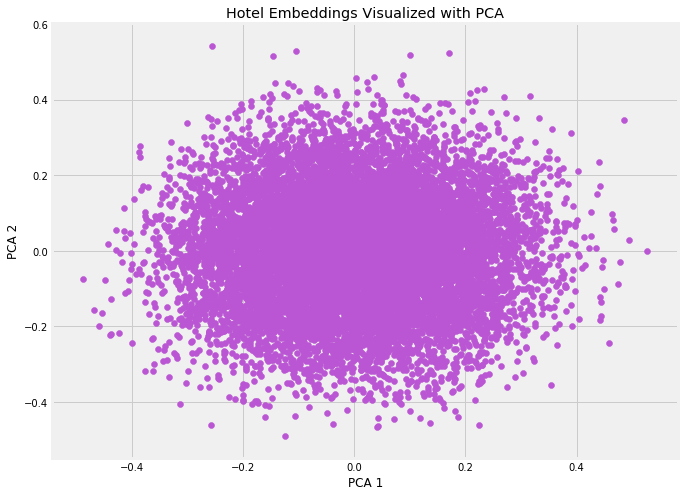

In [37]:
# Visualize PCA output
plt.figure(figsize = (10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c = "mediumorchid")
plt.xlabel("PCA 1"); plt.ylabel("PCA 2"); plt.title("Hotel Embeddings Visualized with PCA");

In [38]:
def count_items(list_items):
    
    # Create a counter object
    counts = Counter(list_items)
    
    # Sort by highest count first and place in ordered dictionary
    counts = sorted(counts.items(), key = lambda x: x[1], reverse = True)
    counts = OrderedDict(counts)
    
    return counts

In [127]:
# Get top ten cities
city_counts = count_items(city_list)
list(city_counts.items())[:20]

# Include 10 most popular cities
cities_to_include = list(city_counts.keys())[:10]

idx_include = []
cities = []
hotels = []

for index, row in hotels_df.iterrows():
    if index < len(hotel_weights):
        if hotels_df.at[index, "city"] in cities_to_include:
            idx_include.append(index)
            cities.append(hotels_df.at[index, "city"])
            hotels.append(hotels_df.at[index, "hotel_name"])


In [128]:
# Map cities to integers to plot them as colors
ints, cities = pd.factorize(cities)

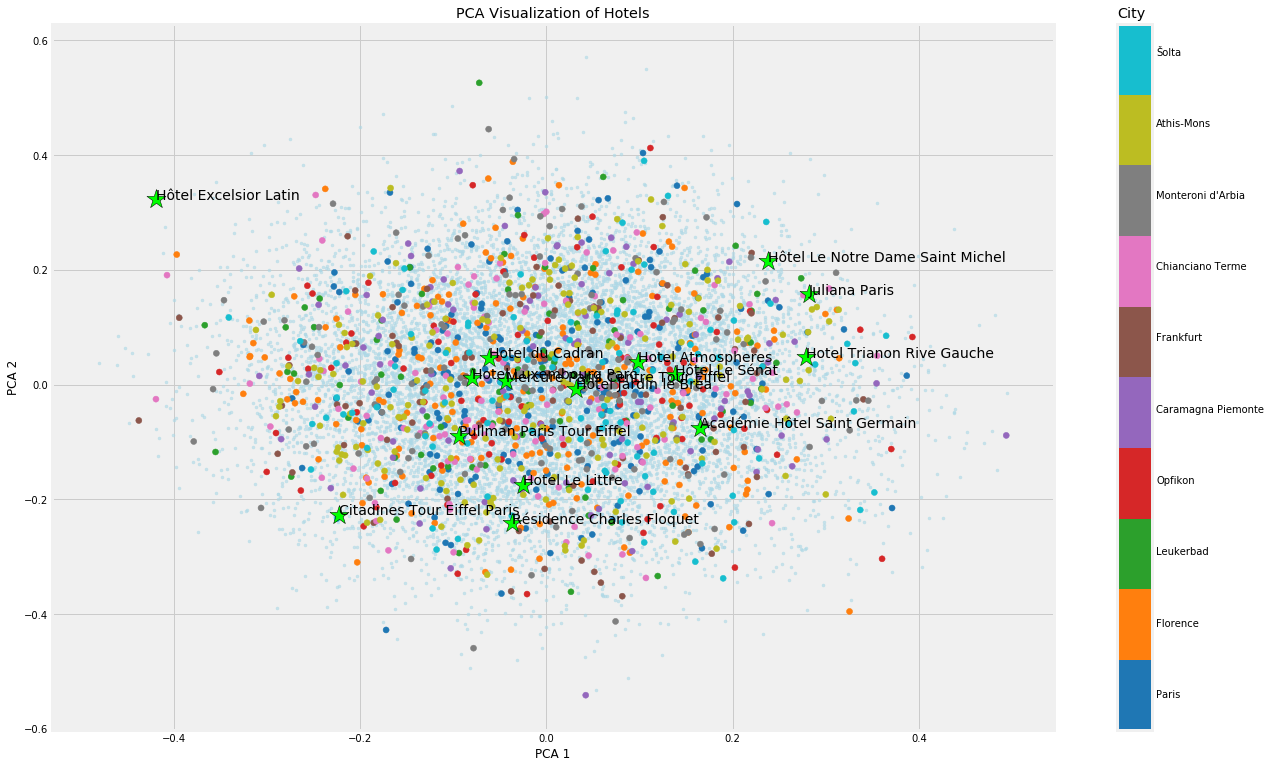

In [140]:
plt.figure(figsize = (20,13))

# Plot all hotels
plt.scatter(pca_result[:, 0], pca_result[:, 1], marker = ".", color = "lightblue", alpha = 0.6)

# Plot embedding
plt.scatter(pca_result[idx_include, 0], pca_result[idx_include, 1], 
            c = ints, cmap = plt.cm.tab10)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(cities):
    cbar.ax.text(10, (2 * j + 1) / ((1.1) * 2), lab, ha = "left", va = "center")
cbar.ax.set_title("City", loc = "left")
cbar.ax.get_yaxis().labelpad = 15


plt.xlabel("PCA 1"); plt.ylabel("PCA 2"); plt.title("PCA Visualization of Hotels");

for hotel in hotels[:15]:
    
    x, y = pca_result[hotel_index[hotel], 0], pca_result[hotel_index[hotel], 1];
    _ = plt.scatter(x, y, s = 400, color = "lime", marker = "*", edgecolor = "k")
    _ = plt.text(x, y, hotel, fontsize = 14);

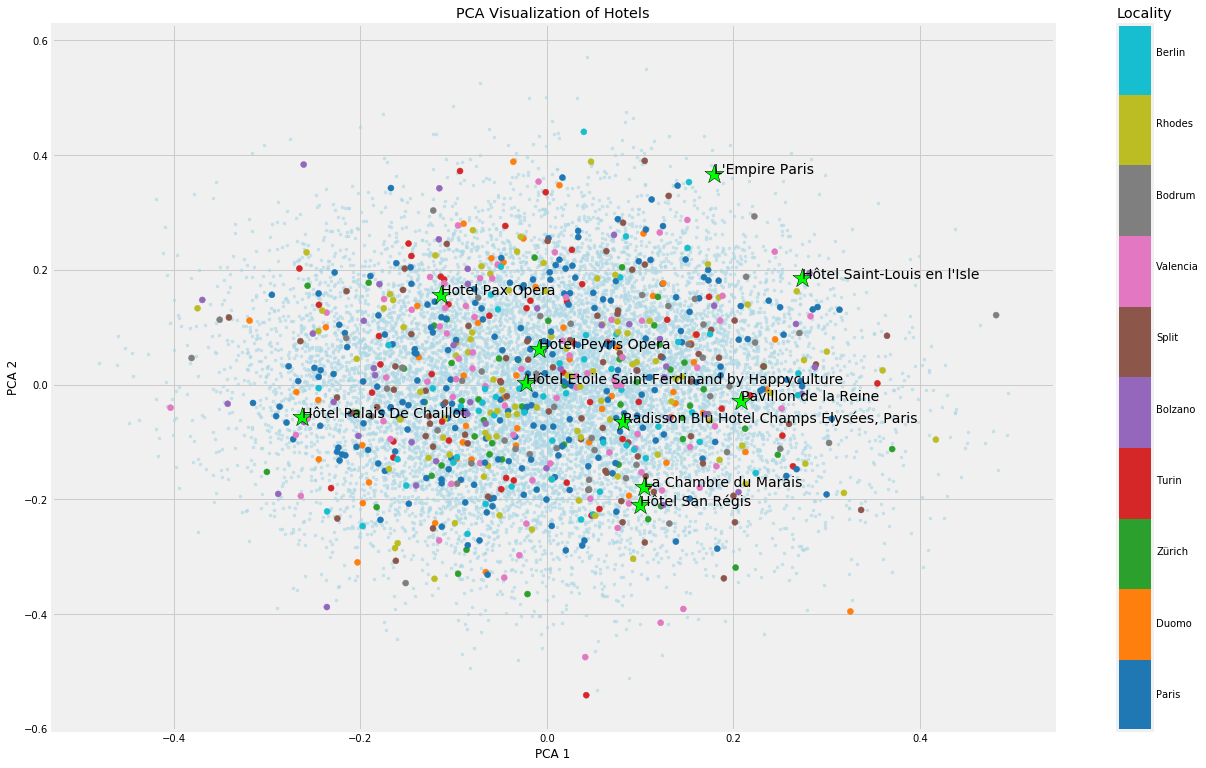

In [145]:
# Get top ten localities
locality_counts = count_items(locality_list)
list(locality_counts.items())[:20]

# Include 10 most popular localities
localities_to_include = list(locality_counts.keys())[:10]

idx_include = []
localities = []
hotels = []

for index, row in hotels_df.iterrows():
    if index < len(hotel_weights):
        if hotels_df.at[index, "locality"] in localities_to_include:
            idx_include.append(index)
            localities.append(hotels_df.at[index, "locality"])
            hotels.append(hotels_df.at[index, "hotel_name"])
            
# Map localities to integers to plot them as colors
ints, localities = pd.factorize(localities)

plt.figure(figsize = (20,13))

# Plot all hotels
plt.scatter(pca_result[:, 0], pca_result[:, 1], marker = ".", color = "lightblue", alpha = 0.6)

# Plot embedding
plt.scatter(pca_result[idx_include, 0], pca_result[idx_include, 1], 
            c = ints, cmap = plt.cm.tab10)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(localities):
    cbar.ax.text(10, (2 * j + 1) / ((1.1) * 2), lab, ha = "left", va = "center")
cbar.ax.set_title("Locality", loc = "left")
cbar.ax.get_yaxis().labelpad = 15


plt.xlabel("PCA 1"); plt.ylabel("PCA 2"); plt.title("PCA Visualization of Hotels");

for hotel in hotels[:10]:
    
    x, y = pca_result[hotel_index[hotel], 0], pca_result[hotel_index[hotel], 1];
    _ = plt.scatter(x, y, s = 400, color = "lime", marker = "*", edgecolor = "k")
    _ = plt.text(x, y, hotel, fontsize = 14);

In [ ]:
# Get top ten localities
locality_counts = count_items(locality_list)
list(locality_counts.items())[:20]

# Include 10 most popular localities
localities_to_include = list(locality_counts.keys())[:10]

idx_include = []
localities = []
hotels = []

for index, row in hotels_df.iterrows():
    if index < len(hotel_weights):
        if hotels_df.at[index, "locality"] in localities_to_include:
            idx_include.append(index)
            localities.append(hotels_df.at[index, "locality"])
            hotels.append(hotels_df.at[index, "hotel_name"])
            
# Map localities to integers to plot them as colors
ints, localities = pd.factorize(localities)

plt.figure(figsize = (20,13))

# Plot all hotels
plt.scatter(pca_result[:, 0], pca_result[:, 1], marker = ".", color = "lightblue", alpha = 0.6)

# Plot embedding
plt.scatter(pca_result[idx_include, 0], pca_result[idx_include, 1], 
            c = ints, cmap = plt.cm.tab10)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(localities):
    cbar.ax.text(10, (2 * j + 1) / ((1.1) * 2), lab, ha = "left", va = "center")
cbar.ax.set_title("Locality", loc = "left")
cbar.ax.get_yaxis().labelpad = 15


plt.xlabel("PCA 1"); plt.ylabel("PCA 2"); plt.title("PCA Visualization of Hotels");

for hotel in hotels[:10]:
    
    x, y = pca_result[hotel_index[hotel], 0], pca_result[hotel_index[hotel], 1];
    _ = plt.scatter(x, y, s = 400, color = "lime", marker = "*", edgecolor = "k")
    _ = plt.text(x, y, hotel, fontsize = 14);